# Continuous Features Evaluation Report

In [374]:
# Imports
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import sklearn.metrics 
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

import numpy as np
import pylab as pl
import csv


In [375]:
# taken and modified from sklearn to load csv in scikit learn standard format
class Bunch(dict):

    def __init__(self, **kwargs):
        super(Bunch, self).__init__(kwargs)

    def __setattr__(self, key, value):
        self[key] = value

    def __dir__(self):
        return self.keys()

    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)

    def __setstate__(self, state):
        pass

cont_infile_name = '../data/preprocessed_divvy_weather/evaluation_continuous.csv'

def load_divydata(return_X_y=False):  
    with open(cont_infile_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        n_samples = int(temp[0])
        n_features = int(temp[1])
        data = np.empty((n_samples, n_features))
        target = np.empty((n_samples,))
        temp = next(data_file)
        feature_names = np.array(temp)

        for i, d in enumerate(data_file):
            data[i] = np.asarray(d[:-1], dtype=np.float64)
            target[i] = np.asarray(d[-1], dtype=np.float64)

    if return_X_y:
        return data, target

    return Bunch(data=data,
                 target=target,
                 feature_names=feature_names[:-1])

In [376]:
# Load data set
divy = load_divydata()
print (divy.feature_names)

['TemperatureF' 'Dew_PointF' 'Humidity' 'Sea_Level_PressureIn' 'VisibilityMPH' 'Wind_SpeedMPH' 'WindDirDegrees']


In [377]:
#Printing data shape features and instances.
data_shape = divy.data.shape
print("Divy Data Shape:")
print("Instances: ",data_shape[0])
print("Features: ",data_shape[1])

Divy Data Shape:
Instances:  2057
Features:  7


# Performance Indicators

### We are using root square error, RMSE and R2 score as our performance measure for regression. 
Our trained model must work better then predicting mean. If we are only predicting near to mean then its almost similar in classification that one is predicting the mode class.
R^2 is coefficient of deteremination. 
R^2 = 1-RSE. bigger the R^2 means better the model is.
If RSE is closer to 1, it means our performance is only comparable to predicting the mean, it is a bad trained model.
If RSE is closer to zero, this indicates a better fit on data.

y:  True Function

g:  Estimated Function

u: Mean of True Function

$$RSE=\sum_{i=0}^\infty \frac{(y - g)^2}{(y - u)^2}$$

One problem with the R2 as a measure of model validity is that, it can always be increased by adding more variables into the model, except in the unlikely event that the additional variables are exactly uncorrelated with the dependent variable in the data sample being used.

Outliers may also give a distorted value of R^2.

In [378]:
# Setting print format
np.set_printoptions(precision=2, linewidth=120, suppress=True, edgeitems=4)

In [379]:
# Adding Bias term x0 in data set.
x = np.array([np.concatenate((v,[1])) for v in divy.data])

In [380]:
# Assign target data to target variable y
y = divy.target

In [381]:
# Helper functions:
# Function to take log of target variable, linear regression sometimes predict -ve values, 
# Keeping target variable on log scale avoids it.
# Below are some fuctions to alter target and prediction on a different scale to avoid this problem.
# Other utility functions

# target variable to log scale
def target_to_ln(y):
    neg_inf = .001
    tmp_t = []
    for t in y:
        if 0==t:
            tmp_t.append(neg_inf)
        else:
            tmp_t.append(np.log(t))
    return tmp_t

# Rescaling of predictions from log
def ln_to_target(p):
    tmp_t = []
    for t in p:
        tmp_t.append(np.exp(t))
    return tmp_t

# Truncate -ve predictions
def truncate_neg_predictions(p):
    t = []
    for items in p:
        if items <0:
            t.append(0)
        else:
            t.append(items)
    return t

# Scaling of target to square root
def scale_var_on_sqrt(var):
    t= []
    t= var
    for index, items in enumerate(t):
        t[index] = np.sqrt(t[index])
    return t

# Rescaling of target from square root
def rescale_var_from_sqrt(var):
    t= []
    t= var
    for index, items in enumerate(t):
        t[index] = np.square(t[index])
    return t

# Cross validation computations for different models
def cross_validation_computations(clf, folds, x, y):
    kf = KFold(len(x), n_folds=folds, shuffle=True)
    xval_err = 0
    z_error = 0
    for train,test in kf:
        clf.fit(x[train],y[train])
        z_ = y[test]
        z_mean = y[test] - np.mean(z_)
        pred = clf.predict(x[test])
        e = pred-y[test]
        xval_err += np.dot(e,e)
        z_error += np.dot(e,e)/np.dot(z_mean,z_mean)

    rmse_10cv = np.sqrt(xval_err/len(x))
    rse_10cv = z_error/folds
    r2_10cv = 1-z_error/folds

    clf.fit(x,y)
    r2_score = cross_val_score(clf, x, y, cv=folds, scoring ='r2')
    return rmse_10cv, rse_10cv, r2_10cv, r2_score

# Computation over trained data
def train_data_computations(clf, x,y):

    #Predicting on train data itself
    pred = clf.predict(x)

    # Errors on train data
    err = abs(pred - y)

    #calculating mean on target variable
    meanr = np.mean(y)
    z = y
    z = abs(z-meanr)
    error = np.dot(err,err)

    # Computing RMSE
    train_rmse_err = np.sqrt(error/len(pred))

    # Computing RSE
    rse_error_pred = error / np.dot(z,z)
    r2_train_error = 1-rse_error_pred
    return meanr, train_rmse_err, rse_error_pred, r2_train_error

# Printing features in decreasing order of coefficients : Shows important features in begining
def prinitng_imp_features(clf):
    
    #print ('Regression Coefficients: \n', clf.coef_)
    a = clf.coef_.tolist()
    b = divy.feature_names.tolist()
    c = list(zip(a,b))
    c.sort(key=lambda k: k[0], reverse=True)
    for iter_ in c:
        print("%.3f  %s" %(iter_[0], iter_[1]))

# Fix the kfolds to 10
test_kfolds = 10

## Models of regression different approach for the project:
1. Linear regression
2. Ridge regression(different alpha values)
3. Lasso regression(different alpha values)
4. All three regression models with polynomial features of degree 2 and degree 3.
5. cross validation 10 folds on all of them.
6. Measures used RMSE, RSE and R2.

# Baseline for regression

### Baseline for Mean Regression

In [382]:
#baseline predictor using dummy regressor
def baseline_predict(x, y):
    y_mean = np.mean(y)
    p_base = np.array([y_mean]*len(y))
    err = abs(p_base-y)
    error = np.dot(err,err)
    train_rmse_err = np.sqrt(error/len(p_base))
    return train_rmse_err, p_base

dummy = DummyRegressor(strategy = 'mean')
dummy.fit(x,y)
p_base = dummy.predict(x)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(dummy, x,y)

#Predicting baseline on train data itself
print("BaseLine mean Regression stats on train data:")
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))
print("R^2 is  \t\t:%.3f"%(r2_train_error))

print("")

rmse_10cv, rse_10cv, r2_10cv, r2_score = cross_validation_computations(dummy, test_kfolds, x, y)
print("BaseLine mean Regression stats on 10fold cv:")
print ("RMSE over train data is: ", rmse_10cv)
print("Rse is  \t\t:%.3f"%( rse_10cv))
#print("R^2 is  \t\t:%.3f"%(r2_10cv))
print("R^2 is  \t\t:%.3f"%(np.mean(r2_score)))

baseline_mean_RMSE =  train_rmse_err
baseline_mean_r2 =  r2_train_error
baseline_mean_RMSE_c =  rmse_10cv
baseline_mean_r2_c =  np.mean(r2_score)

BaseLine mean Regression stats on train data:
MEean of target is : 9.3422459893
RMSE over train data is:  12.9547857905
Rse is  		:1.000
R^2 is  		:0.000
R^2 is  		:0.000

BaseLine mean Regression stats on 10fold cv:
RMSE over train data is:  12.9592031785
Rse is  		:1.003
R^2 is  		:-0.292


### Baseline for Median Regression

In [383]:
dummy = DummyRegressor(strategy = 'median')
dummy.fit(x,y)
p_base = dummy.predict(x)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(dummy, x,y)

#Predicting baseline on train data itself
print("BaseLine median Regression stats on train data:")
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))
print("R^2 is  \t\t:%.3f"%(r2_train_error))

print("")

rmse_10cv, rse_10cv, r2_10cv, r2_score = cross_validation_computations(dummy, test_kfolds, x, y)
print("BaseLine median Regression stats on 10fold cv:")
print ("RMSE over train data is: ", rmse_10cv)
print("Rse is  \t\t:%.3f"%( rse_10cv))
#print("R^2 is  \t\t:%.3f"%(r2_10cv))
print("R^2 is  \t\t:%.3f"%(np.mean(r2_score)))
baseline_median_RMSE =  train_rmse_err
baseline_median_r2 =  r2_train_error
baseline_median_RMSE_c =  rmse_10cv
baseline_median_r2_c =  np.mean(r2_score)


BaseLine median Regression stats on train data:
MEean of target is : 9.3422459893
RMSE over train data is:  14.4239578156
Rse is  		:1.240
R^2 is  		:-0.240
R^2 is  		:-0.240

BaseLine median Regression stats on 10fold cv:
RMSE over train data is:  14.4239578156
Rse is  		:1.244
R^2 is  		:-0.302


# Trying Linear Regression on Linear Features

In [384]:
#Linear regression object
lin_reg = LinearRegression()

#Trying to fit Linear regression object on whole data
lin_reg.fit(x,y)
pred = lin_reg.predict(x)

In [385]:
meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(lin_reg, x,y)

#Predicting on train data itself
print("Linear Regression stats on train data:")
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
print("")
# bigger R^2 indicate a better fit on data.
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))
print("R^2 is  \t\t:%.3f"%(r2_train_error))


Linear Regression stats on train data:
MEean of target is : 9.3422459893
RMSE over train data is:  9.39246473384

Rse is  		:0.526
R^2 is  		:0.474
R^2 is  		:0.474


In [386]:
# high cofficient represents high co-relation with target variable
# printing features in sorted order of cofficient
prinitng_imp_features(lin_reg)

110.350  TemperatureF
26.049  Humidity
9.769  Wind_SpeedMPH
-0.194  VisibilityMPH
-2.884  WindDirDegrees
-4.598  Sea_Level_PressureIn
-83.797  Dew_PointF


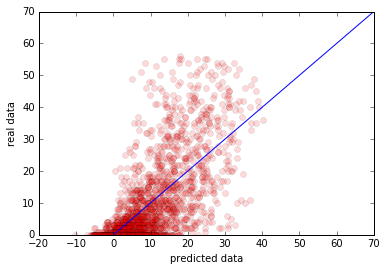

In [387]:
# How well we are doing on train data
# following figure graph shows the how linear regression fits predicted and actual on train data itself.
# It tells us how well it has fit the data itself.

%matplotlib inline
pl.plot(pred, y,'ro', alpha = 0.15)
pl.plot([0,70],[0,70], 'b-')
pl.xlabel('predicted data')
pl.ylabel('real data')
pl.show()


In [388]:
# Cv10 on linear regression
rmse_10cv, rse_10cv, r2_10cv, r2_score = cross_validation_computations(lin_reg, test_kfolds, x, y)
method_name = 'Simple Linear Regression'
print("Stats CV10:")
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %train_rmse_err)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
print('R2 on 10-fold CV: %.4f' %np.mean(r2_score))

lin_reg_RMSE =  train_rmse_err
lin_reg_r2 =  r2_train_error
lin_reg_RMSE_c =  rmse_10cv
line_reg_r2_c =  np.mean(r2_score)

Stats CV10:
Method: Simple Linear Regression
RMSE on training: 9.3925
RMSE on 10-fold CV: 9.4266
R2 on 10-fold CV: 0.4040


# Now trying Ridge Regression on Linear Features

In [389]:
# Creating ridge regression object with a ridge coefficient (alpha) 0.5
ridge_reg = Ridge(fit_intercept=True, alpha=0.5)

# Training the model using the training set
ridge_reg.fit(x,y)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [390]:
# Computing RMSE on training data for ridge regression
meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(ridge_reg, x,y)
print("Stats for ridge: over train data")
method_name = 'Ridge Regression'
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)

# bigger R^2 indicate a better fit on data.
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))

Stats for ridge: over train data
MEean of target is : 9.3422459893
RMSE over train data is:  9.45096993372
Rse is  		:0.532
R^2 is  		:0.468


In [391]:
prinitng_imp_features(ridge_reg)

58.988  TemperatureF
9.380  Wind_SpeedMPH
-3.250  WindDirDegrees
-4.169  VisibilityMPH
-4.838  Humidity
-6.468  Sea_Level_PressureIn
-33.287  Dew_PointF


#### Ridge Regression experiment for different value of alpha.

In [392]:
print('Ridge Regression')
print('alpha\t RMSE_train\t RMSE_10cv\t R2cv10\n')

#different value of alpha
alpha = np.linspace(.01,25,75)
rmse_train_ = np.array([])
rmse_cv10_ = np.array([])
r2_cv10_    = np.array([])
rse_cv10_ = np.array([])

for a in alpha:
    ridge_reg = Ridge(fit_intercept=True, alpha=a)
    ridge_reg.fit(x,y)
    rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(ridge_reg, test_kfolds, x, y)
    pred = ridge_reg.predict(x)
    err = pred-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(pred))
    
    rmse_train_ = np.append(rmse_train_, [rmse_train])
    rmse_cv10_ = np.append(rmse_cv10_, [rmse_cv10])
    rse_cv10_ = np.append(rse_cv10_, [rse_cv10])
    r2_cv10_ = np.append(r2_cv10_, [np.mean(r2_scorecv10)])
    print('{:.3f}\t {:.4f}\t\t {:.4f}\t\t {:.6f}'.format(a,rmse_train,rmse_cv10, np.mean(r2_scorecv10)))

Ridge Regression
alpha	 RMSE_train	 RMSE_10cv	 R2cv10

0.010	 9.3926		 9.4443		 0.403780
0.348	 9.4341		 9.4679		 0.392850
0.685	 9.4671		 9.5022		 0.386658
1.023	 9.4880		 9.5179		 0.383372
1.361	 9.5021		 9.5333		 0.381509
1.699	 9.5124		 9.5361		 0.380418
2.036	 9.5204		 9.5415		 0.379784
2.374	 9.5268		 9.5562		 0.379437
2.712	 9.5321		 9.5593		 0.379278
3.049	 9.5367		 9.5759		 0.379246
3.387	 9.5407		 9.5709		 0.379302
3.725	 9.5444		 9.5780		 0.379418
4.062	 9.5477		 9.5908		 0.379577
4.400	 9.5508		 9.5813		 0.379764
4.738	 9.5538		 9.5819		 0.379970
5.076	 9.5566		 9.5914		 0.380189
5.413	 9.5593		 9.5915		 0.380414
5.751	 9.5619		 9.5897		 0.380641
6.089	 9.5645		 9.5900		 0.380868
6.426	 9.5670		 9.5954		 0.381092
6.764	 9.5695		 9.5986		 0.381310
7.102	 9.5720		 9.6000		 0.381522
7.439	 9.5745		 9.5977		 0.381727
7.777	 9.5769		 9.6072		 0.381923
8.115	 9.5793		 9.6081		 0.382109
8.453	 9.5818		 9.6131		 0.382286
8.790	 9.5842		 9.6145		 0.382452
9.128	 9.5866		 9.6170		 0.

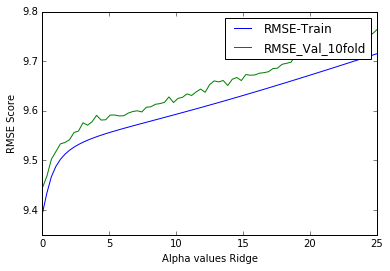

In [393]:
# Graph for 10 fold validation
%matplotlib inline
pl.plot(alpha, rmse_train_, label='RMSE-over-Train')
pl.plot(alpha, rmse_cv10_, label='RMSE_Val_10fold')
pl.legend( ('RMSE-Train', 'RMSE_Val_10fold') )
pl.ylabel('RMSE Score')
pl.xlabel('Alpha values Ridge')
pl.show()

# Trying Lasso Regression on Linear Features

In [394]:
# Create lasson regression object with a lso
lso_reg = Lasso(alpha=0.5)

# Train the model using the training set
lso_reg.fit(x,y)

# Computing RMSE on training data for lasso regression
meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(lso_reg, x,y)

print("Stats for lasso: over train data")
method_name = 'Lasso Regression'

print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
# bigger Rse indicate a better fit on data.
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))

Stats for lasso: over train data
MEean of target is : 9.3422459893
RMSE over train data is:  10.1684547211
Rse is  		:0.616
R^2 is  		:0.384


### Printing Important Features 

In [395]:
prinitng_imp_features(lso_reg)

16.538  TemperatureF
0.000  Dew_PointF
-0.000  Sea_Level_PressureIn
0.000  VisibilityMPH
0.000  Wind_SpeedMPH
-0.000  WindDirDegrees
-15.302  Humidity


### Lasso for different value of alpha:

In [396]:
print('Lasso Regression : ')
print('alpha        RMSE_train        RMSE_10cv        R2cv10\n')

#different value of alpha
alpha = np.linspace(.01,25,75)
rmse_train_ = np.array([])
rmse_cv10_ = np.array([])
r2_cv10_    = np.array([])
rse_cv10_ = np.array([])

for a in alpha:
    lso_reg = Lasso(fit_intercept=True, alpha=a)
    lso_reg.fit(x,y)
    rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(lso_reg, test_kfolds, x, y)
    pred = lso_reg.predict(x)
    err = pred-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(pred))
    
    rmse_train_ = np.append(rmse_train_, [rmse_train])
    rmse_cv10_ = np.append(rmse_cv10_, [rmse_cv10])
    rse_cv10_ = np.append(rse_cv10_, [rse_cv10])
    r2_cv10_ = np.append(r2_cv10_, [np.mean(r2_scorecv10)])
    print('{:.3f}        {:.4f}        {:.4f}        {:.6f}'.format(a,rmse_train,rmse_cv10, np.mean(r2_scorecv10)))

Lasso Regression : 
alpha        RMSE_train        RMSE_10cv        R2cv10

0.010        9.4369        9.4738        0.395857
0.348        9.9683        9.9836        0.355203
0.685        10.5004        10.5087        0.254876
1.023        11.3257        11.3461        0.049879
1.361        12.3856        12.4029        -0.181711
1.699        12.9548        12.9643        -0.291677
2.036        12.9548        12.9573        -0.291677
2.374        12.9548        12.9607        -0.291677
2.712        12.9548        12.9595        -0.291677
3.049        12.9548        12.9623        -0.291677
3.387        12.9548        12.9586        -0.291677
3.725        12.9548        12.9626        -0.291677
4.062        12.9548        12.9655        -0.291677
4.400        12.9548        12.9595        -0.291677
4.738        12.9548        12.9565        -0.291677
5.076        12.9548        12.9582        -0.291677
5.413        12.9548        12.9643        -0.291677
5.751        12.9548        12.

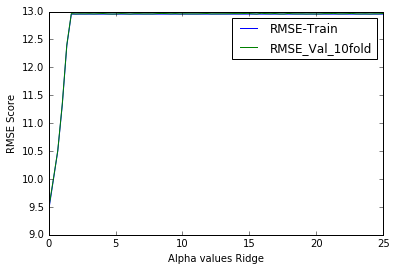

In [397]:
# Graph for 10 fold validation
%matplotlib inline
pl.plot(alpha, rmse_train_, label='RMSE-over-Train')
pl.plot(alpha, rmse_cv10_, label='RMSE_Val_10fold')
pl.legend( ('RMSE-Train', 'RMSE_Val_10fold') )
pl.ylabel('RMSE Score')
pl.xlabel('Alpha values Ridge')
pl.show()

# Creating Polynomial Regression of Degree 2


In [398]:
poly = PolynomialFeatures(degree=2)
x_new = poly.fit_transform(x)
x_old = x

In [399]:
print("Original Data Shape = ", x.shape)
print("Polynomial Degree 2 Data Shape = ", x_new.shape)

Original Data Shape =  (2057, 8)
Polynomial Degree 2 Data Shape =  (2057, 45)


# Linear Regression on Polynomial Features of Degree 2

In [400]:
#Linear regression object
x=x_new

lin_reg = LinearRegression()
lin_reg.fit(x_new, y)
pred = lin_reg.predict(x_new)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(lin_reg, x_new,y)
#Predicting on train data itself
print("Poly Linear Regression(degree-2) stats on train data:")
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
# bigger R^2 indicate a better fit on data.
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))

Poly Linear Regression(degree-2) stats on train data:
MEean of target is : 9.3422459893
RMSE over train data is:  9.1823682433
Rse is  		:0.502
R^2 is  		:0.498


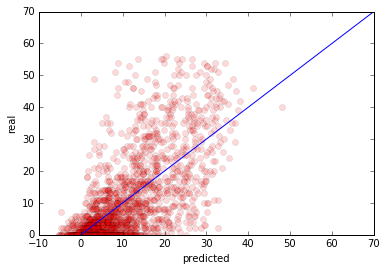

In [401]:
# This graph shows the how linear regression fits between both predicted and actual on training data itself.

# It tells us how well it has fit the data itself, for sure its not over fitting.
# Plot outputs
%matplotlib inline
pl.plot(pred, y,'ro', alpha = .15)
pl.plot([0,70],[0,70], 'b-')
pl.xlabel('predicted')
pl.ylabel('real')
pl.show()

In [402]:
# Cross Validation
rmse_10cv, rse_10cv, r2_10cv, r2_score = cross_validation_computations(lin_reg, test_kfolds, x, y)
method_name = 'Polynomial Linear Regression(degree-2)'
print("Stats CV10:")
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %train_rmse_err)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
#print('RSE on 10-fold CV: %.4f' %rse_10cv)
print('R^2 on CV=10: %.4f' %np.mean(r2_score))

Stats CV10:
Method: Polynomial Linear Regression(degree-2)
RMSE on training: 9.1824
RMSE on 10-fold CV: 9.3747
R^2 on CV=10: 0.3476


# Trying Ridge Regression on Polynomial Features Degree 2

In [403]:
# Creating ridge regression object with a ridge coefficient 0.5
ridge_reg = Ridge(fit_intercept=True, alpha=2.712) # alpha from exp in cell below where diff value of alpha tried

# Training the model using the training set
ridge_reg.fit(x,y)

pred = ridge_reg.predict(x)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(ridge_reg, x,y)
print("Stats for poly ridge(degree-2): over train data")
method_name = 'Ridge Regression'
print("MEean of target is :", meanr)
# bigger R^2 indicate a better fit on data.
print("RMSE is  \t\t:%.3f"%( train_rmse_err))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))
print(" ")
print("Imp Features")
prinitng_imp_features(ridge_reg)

Stats for poly ridge(degree-2): over train data
MEean of target is : 9.3422459893
RMSE is  		:9.313
R^2 is  		:0.483
 
Imp Features
13.277  Dew_PointF
3.319  WindDirDegrees
1.266  Wind_SpeedMPH
0.000  TemperatureF
-0.252  VisibilityMPH
-1.265  Humidity
-7.558  Sea_Level_PressureIn


In [404]:
rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(ridge_reg, test_kfolds, x, y)
method_name = 'Ridge poly Regression(degree-2) CV10'
print('Method: %s' %method_name)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
print('R2 score on 10-fold CV: %.4f' %np.mean(r2_scorecv10))



Method: Ridge poly Regression(degree-2) CV10
RMSE on 10-fold CV: 9.3747
R2 score on 10-fold CV: 0.4045


#### Ridge Regression over Different Values of Alpha for Polynomial Degree 2

In [405]:
print('Poly (Degree-2) Ridge Regression')
print('alpha\t RMSE_train\t RMSE_10cv\t R2cv10\n')

#different value of alpha
alpha = np.linspace(.01,25,75)
rmse_train_ = np.array([])
rmse_cv10_ = np.array([])
r2_cv10_    = np.array([])
rse_cv10_ = np.array([])

for a in alpha:
    ridge_reg = Ridge(fit_intercept=True, alpha=a)
    ridge_reg.fit(x,y)
    rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(ridge_reg, test_kfolds, x, y)
    pred = ridge_reg.predict(x)
    err = pred-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(pred))
    
    rmse_train_ = np.append(rmse_train_, [rmse_train])
    rmse_cv10_ = np.append(rmse_cv10_, [rmse_cv10])
    rse_cv10_ = np.append(rse_cv10_, [rse_cv10])
    r2_cv10_ = np.append(r2_cv10_, [np.mean(r2_scorecv10)])
    print('{:.3f}\t {:.4f}\t\t {:.4f}\t\t {:.6f}'.format(a,rmse_train,rmse_cv10, np.mean(r2_scorecv10)))

Poly (Degree-2) Ridge Regression
alpha	 RMSE_train	 RMSE_10cv	 R2cv10

0.010	 9.2016		 9.3462		 0.379480
0.348	 9.2593		 9.3390		 0.398557
0.685	 9.2713		 9.3645		 0.401282
1.023	 9.2802		 9.3604		 0.402653
1.361	 9.2878		 9.3590		 0.403473
1.699	 9.2947		 9.3701		 0.403977
2.036	 9.3011		 9.3643		 0.404271
2.374	 9.3073		 9.3683		 0.404416
2.712	 9.3133		 9.3656		 0.404451
3.049	 9.3191		 9.3904		 0.404402
3.387	 9.3247		 9.3715		 0.404288
3.725	 9.3301		 9.4047		 0.404125
4.062	 9.3354		 9.4166		 0.403924
4.400	 9.3406		 9.3831		 0.403693
4.738	 9.3456		 9.4059		 0.403440
5.076	 9.3505		 9.4052		 0.403170
5.413	 9.3553		 9.4127		 0.402887
5.751	 9.3599		 9.4387		 0.402596
6.089	 9.3644		 9.4217		 0.402299
6.426	 9.3688		 9.4194		 0.401998
6.764	 9.3731		 9.4149		 0.401695
7.102	 9.3773		 9.4299		 0.401393
7.439	 9.3813		 9.4398		 0.401091
7.777	 9.3853		 9.4403		 0.400792
8.115	 9.3891		 9.4463		 0.400496
8.453	 9.3929		 9.4523		 0.400204
8.790	 9.3965		 9.4538		 0.399916
9.128	 9.40

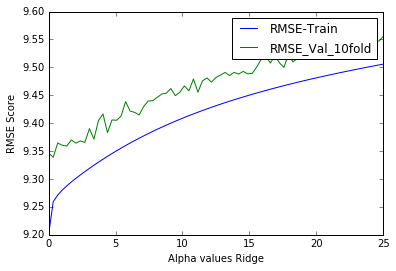

In [406]:
# Graph for 10 fold validation
%matplotlib inline
pl.plot(alpha, rmse_train_, label='RMSE-over-Train')
pl.plot(alpha, rmse_cv10_, label='RMSE_Val_10fold')
pl.legend( ('RMSE-Train', 'RMSE_Val_10fold') )
pl.ylabel('RMSE Score')
pl.xlabel('Alpha values Ridge')
pl.show()

# Trying Lasso on Polynomial Features of Degree 2

In [407]:
# Create Lasso regression object
lso = Lasso(alpha = 0.5)

# Train the model using the training set
lso.fit(x,y)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(lso, x,y)

# Compute RMSE on training data
p = lso.predict(x)
err = p-y
total_error = np.dot(err,err)
rmse_train = np.sqrt(total_error/len(p))

# Compute RMSE using 10-fold x-validation
kf = KFold(len(x), n_folds=test_kfolds, shuffle=True)
xval_err = 0
for train,test in kf:
    lso.fit(x[train],y[train])
    p = lso.predict(x[test])
    e = p-y[test]
    xval_err += np.dot(e,e)
rmse_10cv = np.sqrt(xval_err/len(x))

method_name = 'Lasso Regression(degree-2)'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
print ("r^2 = : ", r2_train_error)
#print ('Regression Coefficients: \n', lso.coef_)
# Important top 10 features in decreasing order of cofficient

rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(lso, test_kfolds, x, y)

print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_cv10)
print('R2 on 10-fold CV: %.4f' %np.mean(r2_scorecv10))

Method: Lasso Regression(degree-2)
RMSE on training: 10.1130
RMSE on 10-fold CV: 10.1263
r^2 = :  0.390598645661
RMSE on training: 10.1130
RMSE on 10-fold CV: 10.1353
R2 on 10-fold CV: 0.3126


### Lasso Regressioin for Different Values of Alpha

In [408]:
print('Lasso Regression : ')
print('alpha        RMSE_train        RMSE_10cv        R2cv10\n')

#different value of alpha
alpha = np.linspace(.01,25,75)
rmse_train_ = np.array([])
rmse_cv10_ = np.array([])
r2_cv10_    = np.array([])
rse_cv10_ = np.array([])

for a in alpha:
    lso_reg = Lasso(fit_intercept=True, alpha=a)
    lso_reg.fit(x,y)
    rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(lso_reg, test_kfolds, x, y)
    pred = lso_reg.predict(x)
    err = pred-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(pred))
    
    rmse_train_ = np.append(rmse_train_, [rmse_train])
    rmse_cv10_ = np.append(rmse_cv10_, [rmse_cv10])
    rse_cv10_ = np.append(rse_cv10_, [rse_cv10])
    r2_cv10_ = np.append(r2_cv10_, [np.mean(r2_scorecv10)])
    print('{:.3f}        {:.4f}        {:.4f}        {:.6f}'.format(a,rmse_train,rmse_cv10, np.mean(r2_scorecv10)))

Lasso Regression : 
alpha        RMSE_train        RMSE_10cv        R2cv10



/home/singh/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/singh/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/singh/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.010        9.3052        9.3747        0.403592
0.348        9.9282        9.9493        0.342040
0.685        10.4201        10.4350        0.256871
1.023        11.1862        11.2087        0.096254
1.361        12.1930        12.2145        -0.137478
1.699        12.9548        12.9635        -0.291003
2.036        12.9548        12.9579        -0.291677
2.374        12.9548        12.9608        -0.291677
2.712        12.9548        12.9643        -0.291677
3.049        12.9548        12.9582        -0.291677
3.387        12.9548        12.9606        -0.291677
3.725        12.9548        12.9564        -0.291677
4.062        12.9548        12.9624        -0.291677
4.400        12.9548        12.9583        -0.291677
4.738        12.9548        12.9580        -0.291677
5.076        12.9548        12.9614        -0.291677
5.413        12.9548        12.9615        -0.291677
5.751        12.9548        12.9642        -0.291677
6.089        12.9548        12.9632        -0.291677
6

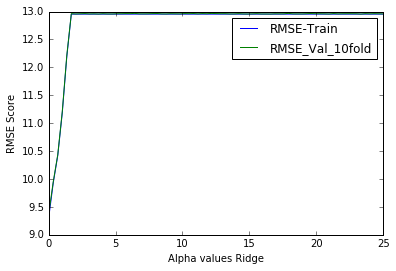

In [409]:
# Graph for 10 fold validation
%matplotlib inline
pl.plot(alpha, rmse_train_, label='RMSE-over-Train')
pl.plot(alpha, rmse_cv10_, label='RMSE_Val_10fold')
pl.legend( ('RMSE-Train', 'RMSE_Val_10fold') )
pl.ylabel('RMSE Score')
pl.xlabel('Alpha values Ridge')
pl.show()

# Creating a Polynomial Regression of degree 3

In [410]:
poly = PolynomialFeatures(degree=3)
x_new = poly.fit_transform(x_old)

In [411]:
#print("Original Data Shape = ", x.shape)
print("Polynomial Degree 3 Data Shape = ", x_new.shape)

Polynomial Degree 3 Data Shape =  (2057, 165)


# Trying Linear Regression over Polynomial Features of Degree 3

In [412]:
#Linear regression object
x=x_new

lin_reg = LinearRegression()

#Trying to fit Linear regression object on whole data
#lin_reg.fit(x,y)
lin_reg.fit(x_new, y)
pred = lin_reg.predict(x_new)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(lin_reg, x_new,y)

#Predicting on train data itself
print("Ploy Linear Regression degree-3 stats on train data:")
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
# Important features in decreasing order of cofficient

# bigger R^2 indicate a better fit on data.
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))


Ploy Linear Regression degree-3 stats on train data:
MEean of target is : 9.3422459893
RMSE over train data is:  8.780000924
Rse is  		:0.459
R^2 is  		:0.541


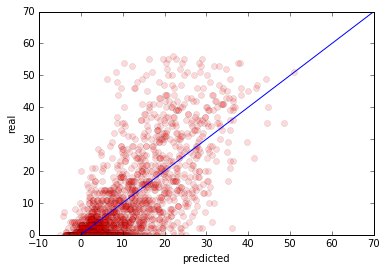

In [413]:
# This graph shows the how linear regression fits between both predicted and actual on training data itself.

# It tells us how well it has fit the data itself
# Plot outputs
%matplotlib inline
pl.plot(pred, y,'ro', alpha = .15)
pl.plot([0,70],[0,70], 'b-')
pl.xlabel('predicted')
pl.ylabel('real')
pl.show()

In [414]:
rmse_10cv, rse_10cv, r2_10cv, r2_score = cross_validation_computations(lin_reg, test_kfolds, x, y)
method_name = 'Polynomial Linear Regression(degree-3)'
print("Stats CV10:")
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %train_rmse_err)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
print('R^2 on CV=10: %.4f' %np.mean(r2_score))

Stats CV10:
Method: Polynomial Linear Regression(degree-3)
RMSE on training: 8.7800
RMSE on 10-fold CV: 10.0233
R^2 on CV=10: -0.5243


# Trying Ridge Regression on Polynomial Features of Degree 3

In [415]:
# Creating ridge regression object with a ridge coefficient 0.5
ridge_reg = Ridge(fit_intercept=True, alpha=0.5)

# Training the model using the training set
ridge_reg.fit(x,y)

pred = ridge_reg.predict(x)

# Computing RMSE on training data for ridge regression
meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(ridge_reg, x,y)
print("Stats for poly ridge degree-3: over train data")
method_name = 'Ridge Regression'
print("MEean of target is :", meanr)
print("RMSE of target is :", train_rmse_err)

# bigger R^2 indicate a better fit on data.
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))


Stats for poly ridge degree-3: over train data
MEean of target is : 9.3422459893
RMSE of target is : 9.1249131893
Rse is  		:0.496
R^2 is  		:0.504


In [416]:
rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(ridge_reg, test_kfolds, x, y)
method_name = 'Ridge poly Regression degree-3 CV10'
print('Method: %s' %method_name)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
print('R2 score on 10-fold CV: %.4f' %np.mean(r2_scorecv10))

Method: Ridge poly Regression degree-3 CV10
RMSE on 10-fold CV: 10.0233
R2 score on 10-fold CV: 0.3952


In [417]:
print('Ridge Regression(degree-3)')
print('alpha\t RMSE_train\t RMSE_10cv\t R2cv10\n')

#different value of alpha
alpha = np.linspace(.01,25,40)
rmse_train_ = np.array([])
rmse_cv10_ = np.array([])
r2_cv10_    = np.array([])
rse_cv10_ = np.array([])

for a in alpha:
    ridge_reg = Ridge(fit_intercept=True, alpha=a)
    ridge_reg.fit(x,y)
    rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(ridge_reg, test_kfolds, x, y)
    pred = ridge_reg.predict(x)
    err = pred-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(pred))
    
    rmse_train_ = np.append(rmse_train_, [rmse_train])
    rmse_cv10_ = np.append(rmse_cv10_, [rmse_cv10])
    rse_cv10_ = np.append(rse_cv10_, [rse_cv10])
    r2_cv10_ = np.append(r2_cv10_, [np.mean(r2_scorecv10)])
    print('{:.3f}\t {:.4f}\t\t {:.4f}\t\t {:.6f}'.format(a,rmse_train,rmse_cv10, np.mean(r2_scorecv10)))

Ridge Regression(degree-3)
alpha	 RMSE_train	 RMSE_10cv	 R2cv10

0.010	 8.9331		 9.1919		 0.205714
0.651	 9.1436		 9.2630		 0.397063
1.292	 9.1915		 9.3026		 0.399541
1.932	 9.2177		 9.3173		 0.400108
2.573	 9.2351		 9.3230		 0.400341
3.214	 9.2479		 9.3480		 0.400477
3.855	 9.2580		 9.3419		 0.400573
4.495	 9.2665		 9.3611		 0.400645
5.136	 9.2737		 9.3558		 0.400698
5.777	 9.2802		 9.3529		 0.400735
6.418	 9.2859		 9.3582		 0.400758
7.058	 9.2912		 9.3787		 0.400766
7.699	 9.2962		 9.3680		 0.400761
8.340	 9.3008		 9.3842		 0.400744
8.981	 9.3052		 9.3864		 0.400715
9.622	 9.3094		 9.3739		 0.400676
10.262	 9.3134		 9.3876		 0.400626
10.903	 9.3172		 9.4177		 0.400567
11.544	 9.3209		 9.3736		 0.400499
12.185	 9.3246		 9.3875		 0.400423
12.825	 9.3281		 9.3986		 0.400339
13.466	 9.3315		 9.3972		 0.400249
14.107	 9.3348		 9.4079		 0.400152
14.748	 9.3381		 9.4076		 0.400049
15.388	 9.3413		 9.4154		 0.399940
16.029	 9.3445		 9.4014		 0.399827
16.670	 9.3476		 9.4139		 0.399709
17.311

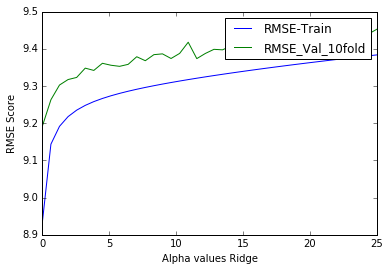

In [418]:
# Graph for 10 fold validation
%matplotlib inline
pl.plot(alpha, rmse_train_, label='RMSE-over-Train')
pl.plot(alpha, rmse_cv10_, label='RMSE_Val_10fold')
pl.legend( ('RMSE-Train', 'RMSE_Val_10fold') )
pl.ylabel('RMSE Score')
pl.xlabel('Alpha values Ridge')
pl.show()

# Trying Lasso on Polynomial Features of Degree 3

In [419]:
# Create lasso regression object with a lso
lso = Lasso(alpha = 0.5)

# Train the model using the training set
lso.fit(x,y)

# Compute RMSE on training data
p = lso.predict(x)
err = p-y
total_error = np.dot(err,err)
rmse_train = np.sqrt(total_error/len(p))

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(lso, x,y)

# Compute RMSE using 10-fold x-validation
kf = KFold(len(x), n_folds=test_kfolds, shuffle=True)
xval_err = 0
for train,test in kf:
    lso.fit(x[train],y[train])
    p = lso.predict(x[test])
    e = p-y[test]
    xval_err += np.dot(e,e)
rmse_10cv = np.sqrt(xval_err/len(x))

method_name = 'Lasso Regression degree-3'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
print('R^2 on Training: %.4f' %r2_train_error)
#print ('Regression Coefficients: \n', lso.coef_)

rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(lso, test_kfolds, x, y)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_cv10)
print('R2 on 10-fold CV: %.4f' %np.mean(r2_scorecv10))

Method: Lasso Regression degree-3
RMSE on training: 10.1130
RMSE on 10-fold CV: 10.1407
R^2 on Training: 0.3906
RMSE on training: 10.1130
RMSE on 10-fold CV: 10.1320
R2 on 10-fold CV: 0.3126


### Lasso for different value of alpha, polynomial degree-3

In [420]:
print('Lasso Regression : ')
print('alpha        RMSE_train        RMSE_10cv        R2cv10\n')

#different value of alpha
alpha = np.linspace(.01,25,40)
rmse_train_ = np.array([])
rmse_cv10_ = np.array([])
r2_cv10_    = np.array([])
rse_cv10_ = np.array([])

for a in alpha:
    lso_reg = Lasso(fit_intercept=True, alpha=a)
    lso_reg.fit(x,y)
    rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(lso_reg, test_kfolds, x, y)
    pred = lso_reg.predict(x)
    err = pred-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(pred))
    
    rmse_train_ = np.append(rmse_train_, [rmse_train])
    rmse_cv10_ = np.append(rmse_cv10_, [rmse_cv10])
    rse_cv10_ = np.append(rse_cv10_, [rse_cv10])
    r2_cv10_ = np.append(r2_cv10_, [np.mean(r2_scorecv10)])
    print('{:.3f}        {:.4f}        {:.4f}        {:.6f}'.format(a,rmse_train,rmse_cv10, np.mean(r2_scorecv10)))

Lasso Regression : 
alpha        RMSE_train        RMSE_10cv        R2cv10



/home/singh/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/singh/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/singh/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/singh/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not conver

0.010        9.2749        9.3450        0.402971
0.651        10.3562        10.3683        0.268945
1.292        11.9645        11.9901        -0.083120
1.932        12.9548        12.9602        -0.291677
2.573        12.9548        12.9646        -0.291677
3.214        12.9548        12.9717        -0.291677
3.855        12.9548        12.9650        -0.291677
4.495        12.9548        12.9641        -0.291677
5.136        12.9548        12.9650        -0.291677
5.777        12.9548        12.9656        -0.291677
6.418        12.9548        12.9633        -0.291677
7.058        12.9548        12.9663        -0.291677
7.699        12.9548        12.9698        -0.291677
8.340        12.9548        12.9664        -0.291677
8.981        12.9548        12.9569        -0.291677
9.622        12.9548        12.9589        -0.291677
10.262        12.9548        12.9611        -0.291677
10.903        12.9548        12.9617        -0.291677
11.544        12.9548        12.9594        -0.2

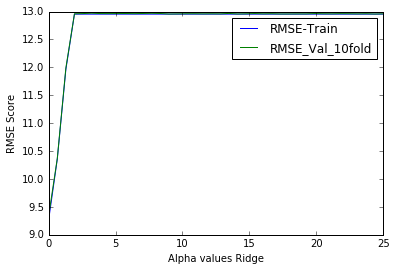

In [421]:
# Graph for 10 fold validation
%matplotlib inline
pl.plot(alpha, rmse_train_, label='RMSE-over-Train')
pl.plot(alpha, rmse_cv10_, label='RMSE_Val_10fold')
pl.legend( ('RMSE-Train', 'RMSE_Val_10fold') )
pl.ylabel('RMSE Score')
pl.xlabel('Alpha values Ridge')
pl.show()

# Best Model Performance Summary : (Continuous Features)

#### Best Model : Ridge Regression polynomial degree 2, for alpha = 2.712

#### Table for RMSE:

|Model|     Baseline(Mean)    |     Baseline(Median)    |   Best model   |
|-----|-----------------------|-------------------------|----------------|
|Train|     12.954            |       14.423            |    9.3133      |
|CV10 |     12.957            |       14.424            |    9.3802      |


#### Table for R2 Score

|Model|     Baseline(Mean)    |     Baseline(Median)    |   Best model   |
|-----|-----------------------|-------------------------|----------------|
|Train|        0              |       -.240             |     0.400      |
|CV10 |       -.292           |       -.302             |     0.404      |



### Important Features :
|Coefficient|     Feature Name    |
|-----------|---------------------|
|13.277     |Dew_PointF           |
|3.319      |WindDirDegrees       |
|1.266      |Wind_SpeedMPH        |
|0.000      |TemperatureF         |
|-0.252     |VisibilityMPH        |
|-1.265     |Humidity             |
|-7.558     |Sea_Level_PressureIn |